<a href="https://colab.research.google.com/github/Monica-Lu/Data_Science_Research/blob/main/RNN_LSTM_GRU_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM Multivariate: https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate/code
####No: row number
####year: year of data in this row
####month: month of data in this row
####day: day of data in this row
####hour: hour of data in this row
####pm2.5: PM2.5 concentration
####DEWP: Dew Point
####TEMP: Temperature
####PRES: Pressure
####cbwd: Combined wind direction
####Iws: Cumulated wind speed
####Is: Cumulated hours of snow
####Ir: Cumulated hours of rain

Blog: https://bobrupakroy.medium.com/multi-variate-lstm-time-series-forecasting-1a736009f6d


In [1]:
import kagglehub
path=kagglehub.dataset_download("rupakroy/lstm-datasets-multivariate-univariate")
print(path)

/kaggle/input/lstm-datasets-multivariate-univariate


In [2]:
import os
for dir_name, _, filenames in os.walk('/root/.cache/kagglehub/datasets'):
  for filename in filenames:
    print(os.path.join(dir_name, filename))

/root/.cache/kagglehub/datasets/rupakroy/lstm-datasets-multivariate-univariate/4.complete
/root/.cache/kagglehub/datasets/rupakroy/lstm-datasets-multivariate-univariate/versions/4/pollution_test_data1.csv
/root/.cache/kagglehub/datasets/rupakroy/lstm-datasets-multivariate-univariate/versions/4/LSTM-Multivariate_pollution.csv


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
#Function of multivariate LSTM time series forecasting from blog

#Transform series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  #input seq (t-n, ..., t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    if i == 0:
      #generate columns for multivariate time series
      #Format looks like var1(t-3), var2(t-3), ..., var1(t-2), var2(t-2), ..., var1(t), var2(t)
      #useful when transform a time series into supervised learning dataset
      #X(t-3), X(t-2), X(t-1) → Y(t)
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

  #put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  #drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
    return agg

In [5]:
#Load Dataset
df_train = pd.read_csv("/root/.cache/kagglehub/datasets/rupakroy/lstm-datasets-multivariate-univariate/versions/4/LSTM-Multivariate_pollution.csv", header = 0, index_col = 0)
df_test = pd.read_csv("/root/.cache/kagglehub/datasets/rupakroy/lstm-datasets-multivariate-univariate/versions/4/pollution_test_data1.csv")
print(df_train.head())
print(df_test.head())


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
   dew  temp  press wnd_dir  wnd_spd  snow  rain  pollution
0  -16     4   1027      SE     3.58     0     0        128
1  -17     5   1027      SE     7.60     0     0         77
2  -16     4   1027      SE     9.39     0     0         65
3  -16     1   1028      cv     0.89     0     0         79
4  -14     0   1028      NE     1.79     0     0         93


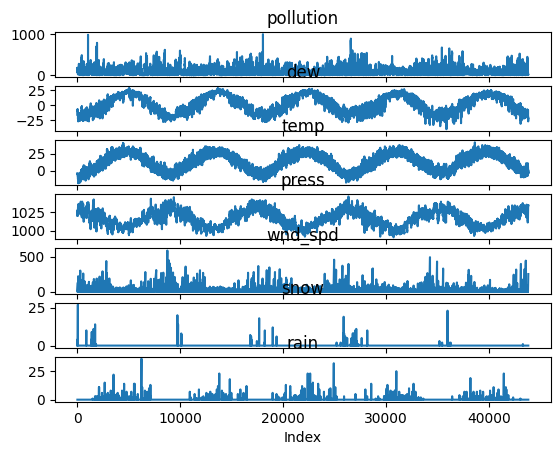

In [6]:
import matplotlib.pyplot as plt

values = df_train.values

#specify columns to plot
groups = [1,2,3,4,6,7,8]
i = 1

plt.figure()
for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, group-1])
  plt.xlabel('Index')
  plt.title(df_train.columns[group-1])
  i+=1
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed

,var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var6(t+1),var7(t+1),var8(t+1)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0


In [8]:
#Split into train and test sets
values = reframed.values
n_train_hours = 365 * 36
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print("train X", train_X[:5], "\n\n\n",
      "train y", train_y[:5], "\n\n\n",
      "test X", test_X[:5], "\n\n\n",
      "test y",test_y[:5])

(13140, 1, 7) (13140,) (30659, 1, 7) (30659,)
train X [[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
   0.        ]]

 [[0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
   0.        ]]

 [[0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
   0.        ]]

 [[0.18209255 0.48529413 0.22950819 0.5636368  0.6666667  0.00839101
   0.03703704]]

 [[0.13883299 0.48529413 0.22950819 0.5636368  0.6666667  0.00991199
   0.07407407]]] 


 train y [0. 0. 0. 0. 0.] 


 test X [[[0.03018109 0.8235294  0.83606553 0.20000076 0.33333334 0.00458002
   0.        ]]

 [[0.02615694 0.8088236  0.85245895 0.20000076 0.33333334 0.00763907
   0.        ]]

 [[0.0251509  0.8088236  0.86885244 0.18181801 1.         0.00458002
   0.        ]]

 [[0.01911469 0.7941177  0.86885244 0.18181801 0.         0.00229001
   0.        ]]

 [[0.02615694 0.8088236  0.86885244 0.18181801 1.         0.00229001
   0.        ]]] 


 test y [0. 0. 0. 0. 0.]


In [10]:
import tensorflow as tf

class VanillaRNN(tf.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.W_xh = tf.Variable(tf.random.normal([input_size, hidden_size]))
        self.W_hh = tf.Variable(tf.random.normal([hidden_size, hidden_size]))
        self.b_h = tf.Variable(tf.zeros([hidden_size]))
        self.W_hy = tf.Variable(tf.random.normal([hidden_size, output_size]))
        self.b_y = tf.Variable(tf.zeros([output_size]))

    def __call__(self, x_seq, h=None):
        # x_seq shape: (batch, timesteps, input_size)
        batch_size = tf.shape(x_seq)[0]
        timesteps = tf.shape(x_seq)[1]
        input_size = tf.shape(x_seq)[2]
        h = tf.zeros((batch_size, self.hidden_size))  # shape: (batch_size, hidden_size)
        print("X_seq_Shape:", batch_size, timesteps, input_size)

        if h is None:
            h = tf.zeros((batch_size, self.hidden_size))
            print("h_prev_shape:", h.shape)

        for t in range(timesteps):
            x_t = x_seq[:, t, :]  # shape: (batch_size, input_size)
            print("X_t_shape:", x_t.shape)
            print("W_xh_shape:", self.W_xh.shape)
            print("h_t-1_shape:", h.shape)
            print("b_h_shape:", self.b_h.shape)
            print("W_hh_shape:", self.W_hh.shape)
            h = tf.tanh(x_t @ self.W_xh + h @ self.W_hh + self.b_h)
            print("h_shape:", h.shape)

        y_hat = h @ self.W_hy + self.b_y  # (batch_size, output_size)
        #print("y_hat_shape:", y_hat)
        return y_hat


In [11]:
#from d2l.ai book
class LSTMLayer(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, sigma=0.01):
        super().__init__()
        self.hidden_size = hidden_size
        init_weight = lambda *shape: self.add_weight(shape=shape,
                                                     initializer=tf.keras.initializers.RandomNormal(stddev=sigma),
                                                     trainable=True)
        triple = lambda: (init_weight(input_size, hidden_size),
                          init_weight(hidden_size, hidden_size),
                          self.add_weight(shape=(hidden_size,),
                                          initializer='zeros',
                                          trainable=True))

        self.W_xi, self.W_hi, self.b_i = triple()
        self.W_xf, self.W_hf, self.b_f = triple()
        self.W_xo, self.W_ho, self.b_o = triple()
        self.W_xc, self.W_hc, self.b_c = triple()

    def __call__(self, inputs, initial_state=None):
        batch_size = tf.shape(inputs)[0]
        timesteps = tf.shape(inputs)[1]
        input_size = tf.shape(inputs)[2]
        print("LSTM Shapes:", batch_size, timesteps, input_size)

        if initial_state is None:
            H = tf.zeros((batch_size, self.hidden_size))
            C = tf.zeros((batch_size, self.hidden_size))
        else:
            H, C = initial_state

        outputs = []
        for t in range(timesteps):
            X = inputs[:, t, :]  # shape: (batch_size, input_size)
            print("X_shape:", X.shape)
            print("W_xi_shape:", self.W_xi.shape)
            print("H_shape:", H.shape)
            print("W_hi_shape:", self.W_hi.shape)
            print("b_i_shape:", self.b_i.shape)
            print("train_X[2]_shape", train_X.shape[2])
            I = tf.sigmoid(tf.matmul(X, self.W_xi) + tf.matmul(H, self.W_hi) + self.b_i)
            F = tf.sigmoid(tf.matmul(X, self.W_xf) + tf.matmul(H, self.W_hf) + self.b_f)
            O = tf.sigmoid(tf.matmul(X, self.W_xo) + tf.matmul(H, self.W_ho) + self.b_o)
            C_tilde = tf.tanh(tf.matmul(X, self.W_xc) + tf.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * tf.tanh(C)
            outputs.append(H)

        outputs = tf.stack(outputs, axis=1)  # shape: (batch_size, timesteps, hidden_size)
        print("LSTM_shape:", outputs.shape)
        return outputs

    def parameters(self):
      return [self.W_xi, self.W_hi, self.b_i,
            self.W_xf, self.W_hf, self.b_f,
            self.W_xo, self.W_ho, self.b_o,
            self.W_xc, self.W_hc, self.b_c]


In [12]:
class DenseOutput(tf.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.W = tf.Variable(tf.random.normal((input_size, output_size)))
        self.b = tf.Variable(tf.zeros((output_size,)))

    def __call__(self, x):
        return x @ self.W + self.b


In [13]:
class MySequentialModel(tf.Module):
    def __init__(self, input_size, rnn_hidden, lstm_hidden, output_size):
        super().__init__()
        self.rnn = VanillaRNN(input_size, rnn_hidden, output_size)
        self.lstm = LSTMLayer(output_size, lstm_hidden)
        self.dense = DenseOutput(lstm_hidden, output_size)

    def __call__(self, x):
        # x shape: (batch, timesteps, input_size)
        rnn_out = self.rnn(x)                 # shape (batch, rnn_hidden)
        rnn_out_seq = tf.expand_dims(rnn_out, axis=1)  # shape (batch, 1, rnn_hidden)
        print("RNN_OUT_SEQ_Shape:", rnn_out_seq.shape)
        lstm_out = self.lstm(rnn_out_seq)  # shape (batch, lstm_hidden)
        return self.dense(lstm_out)

    def parameters(self):
        return (
            list(self.rnn.trainable_variables) +
            list(self.lstm.parameters()) +
            [self.dense.W, self.dense.b]
        )


In [14]:
def train_model(model, train_X, train_y, test_X, test_y, epochs=20, lr=0.001, batch_size=28):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_fn = tf.keras.losses.MeanSquaredError()

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0

        for i in range(0, len(train_X), batch_size):
            x_batch = train_X[i:i+batch_size]
            y_batch = train_y[i:i+batch_size]

            # Make sure shapes are correct
            x_batch = tf.convert_to_tensor(x_batch, dtype=tf.float32)
            y_batch = tf.convert_to_tensor(y_batch, dtype=tf.float32)
            y_batch = tf.expand_dims(y_batch, axis=-1)  # Shape: (batch, 1)
            print("Y_batch_Shape:", y_batch.shape)

            with tf.GradientTape() as tape:
                preds = model(x_batch)
                loss = loss_fn(y_batch, preds)

            grads = tape.gradient(loss, model.parameters())
            optimizer.apply_gradients(zip(grads, model.parameters()))

            total_loss += loss.numpy()
            num_batches += 1

        # Evaluate on test set
        test_preds = model(test_X)
        test_y_exp = tf.expand_dims(test_y, axis=-1)
        test_loss = loss_fn(test_y_exp, test_preds)

        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.6f}, Test Loss = {test_loss.numpy():.6f}")



In [ ]:
model = MySequentialModel(
    input_size=train_X.shape[2],   #(batch_size, timestep, input_size)
    rnn_hidden=32,
    lstm_hidden=32,
    output_size=32
)

train_model(model, train_X, train_y, test_X, test_y, epochs=5)

Streaming output truncated to the last 5000 lines.
b_i_shape: (32,)
train_X[2]_shape 7
LSTM_shape: (28, 1, 32)
Y_batch_Shape: (28, 1)
X_seq_Shape: tf.Tensor(28, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(7, shape=(), dtype=int32)
X_t_shape: (28, 7)
W_xh_shape: (7, 32)
h_t-1_shape: (28, 32)
b_h_shape: (32,)
W_hh_shape: (32, 32)
h_shape: (28, 32)
RNN_OUT_SEQ_Shape: (28, 1, 32)
LSTM Shapes: tf.Tensor(28, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(32, shape=(), dtype=int32)
X_shape: (28, 32)
W_xi_shape: (32, 32)
H_shape: (28, 32)
W_hi_shape: (32, 32)
b_i_shape: (32,)
train_X[2]_shape 7
LSTM_shape: (28, 1, 32)
Y_batch_Shape: (28, 1)
X_seq_Shape: tf.Tensor(28, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(7, shape=(), dtype=int32)
X_t_shape: (28, 7)
W_xh_shape: (7, 32)
h_t-1_shape: (28, 32)
b_h_shape: (32,)
W_hh_shape: (32, 32)
h_shape: (28, 32)
RNN_OUT_SEQ_Shape: (28, 1, 32)
LSTM Shapes: tf.Tensor(28, shape=(), dtype